# Introduction
The dataset included in this project contains information about credit card transactions and their labels as either legitimate or fraudulent transactions. As the vast majority of transactions carried out are legitimate, this is a highly imbalanced dataset. Using different techniques such as undersampling, oversampling, and SMOTE, we will attempt to balance the data and train machine learning models to correctly predict whether a transaction is fraudulent or not.

## Dataset Contents
The dataset contains transactions made by credit cards in September 2013 by European cardholders over a period of two days. 


## Importing the Necessary Libraries
Here we'll begin by importing some of the libraries we'll use in the project.


In [1]:
## libraries for loading and exploring data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## splitting and balancing data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## metrics for evaluating models
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix

## misc
from collections import Counter

## Loading the Data
Next, we'll load the data, found in `creditcard.csv` and print the first few rows to see what we're working with.

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploring the Data
Initial exploration of the data shows a few things. We have 31 columns:
- Time (in seconds, elapsed since first transaction in dataset)
- V1-V28 Primary components which have been transformed into numerical data. For reasons of confidentiality, the true labels of these features are unknown.
- Amount (how much was spent in that transaction)
- Class (0 for legitimate transaction, 1 for fraudulent. From this point on, 0 will be referred to as **legitimate** and 1 as **fraudulent**) 

## Transforming the Data
Most of the data has already been transformed. The only columns that haven't are: `Time`, `Amount` and `Class`. We won't be using time, and class is simply a binary classification of legitimate or fraudulent activity. 

If we want to use `Amount` in our training models, we will need to standardize it so that its values are similar to those in our already transformed data contained within columns V1-V28.

**Note: This process can take a few minutes given the large amount of observations.**

In [3]:
df['Amount'] = df['Amount'].apply(lambda x: (x - df['Amount'].mean()) / (df['Amount'].std()))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0



## Visualizing the Data
As previously mentioned, this is a highly imbalanced dataset. The amount of legitimate transactions are significantly higher than those of fraudulent charges. 

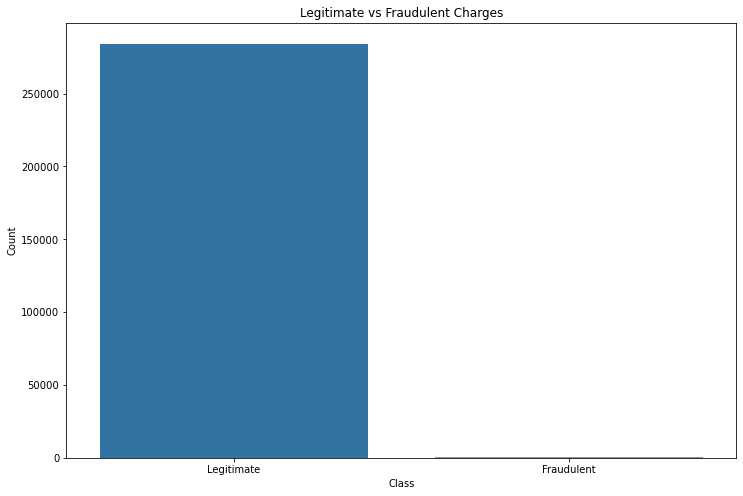

In [4]:
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.countplot(x='Class', data=df)
ax.set_xticklabels(['Legitimate', 'Fraudulent'])
plt.ylabel("Count")
plt.title("Legitimate vs Fraudulent Charges")
plt.show()

In [5]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

The fraudulent class is barely visible on our graph, and it's clear why if we see the normalized value counts for this dataset. Legitimate charges compose 99.82% of the data in this dataset, while fraudulent charges make up only 0.17% of this dataset.

## Imbalanced Data
### Potential Problems
Up to this point, it's been made clear that this dataset is imbalanced, but what exactly does that mean and how does it affect a machine learning model? Let's train a model without altering the data in any way to see what happens. Let's split our data into a training set and testing set as it is, then train a Logistic Regression model on it.

### Splitting the Data

In [6]:
X, y = df.iloc[:, 1:-1].values, df.iloc[:, -1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

### Logistic Regression

In [7]:
lr_imb = LogisticRegression()
lr_imb.fit(X_train, np.ravel(y_train))
lr_imb_predict = lr_imb.predict(X_test)
print(accuracy_score(y_test, lr_imb_predict))

0.9990309260975815


Amazing! This model has 99.9% accuracy!

Machine learning models are commonly scored by measuring accuracy.

<img src="accuracy.png" width="500" height="56" />

The problem with this method is that it overvalues correct predictions when the dataset is imbalanced. Consider assigning this same task to a person. After seeing maybe a hundred rows with no fraudulent charges, they may decide that the smart way to classify data is to simply guess "legitimate" every single time. At the end of the day, they may be wrong once or twice, but they'll be correct 99% of the time.

## Potential Solutions
The solution to this is to either balance the data somehow or more heavily penalize the ML model when it fails to detect a fraudulent case. In other words, find a way to give equal weight to both classifications, so the model will not be incentivized to simply guess one class over and over. We can also evaluate our ML models using different metrics, such as precision, recall, and F1-score.

## Measuring Models Trained on Imbalanced Data

### Measuring Using Precision-Recall Curve
As mentioned previously, we can either balance the data in some way, or we can try to measure our model on a different metric. One way to measure accuracy when data is imbalanced is to calculate the **Area Under Precision-Recall Curve(AUPRC)**. The `auc()` function will let us calculate the area under the curve, while `precision_recall_curve()` will let us create the curve based on our predictions. 

Assuming the model scores highly using precision and recall, even though our data is imbalanced, we could say that it's accurate at predicting fraud.

### Prediction Probability
It won't be enough to have an array with the model's predictions in order to create the curve. We'll need the actual probability that each prediction returned.

In [8]:
lr_imb_probs = lr_imb.predict_proba(X_test)[:, 1]
lr_imb_prec, lr_imb_recall, lr_imb_threshold = precision_recall_curve(y_test, lr_imb_probs)

### Plotting Precision-Recall Curve

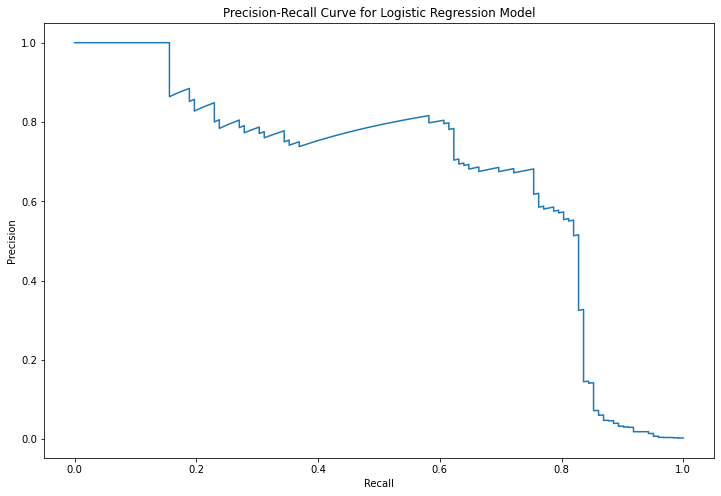

0.6667049835483573


In [9]:
plt.figure(figsize=(12,8))
plt.plot(lr_imb_recall, lr_imb_prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression Model")
plt.show()
print(auc(lr_imb_recall, lr_imb_prec))

### Analysis Using AUPRC (Area Under Precision-Recall Curve)
Unfortunately, the area under the curve was 0.66, which is not very good. The model, while better than a random classifier, makes enough mistakes that it shouldn't be trusted to predict fraud accurately. 

## Undersampled Data

### Random Undersampling
Undersampling allows us to set the majority class equal to the minority class. That means if we have 400 rows that represent fraudulent data, instead of training our model on 20,000+ rows of legitimate transactions and only 400 rows of fraudulent transactions as we did above, we'll undersample our legitimate class to just include 400 rows.

In our particular example, we're using `RandomUnderSampler` to do this. Random undersampling chooses observations from the majority class to be removed at random. Both our classes will now have 492 rows of data that we'll train our ML model on.

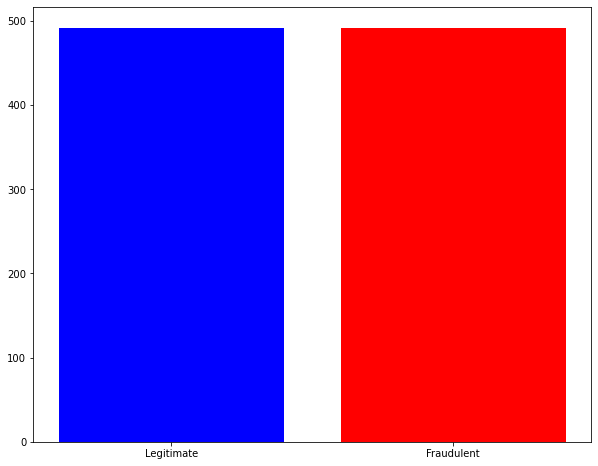

Counter({0: 492, 1: 492})


In [10]:
rus = RandomUnderSampler(random_state=1, replacement=True)
X_rus, y_rus = rus.fit_resample(X,y)
rus_data = Counter(y_rus)
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.bar(rus_data.keys(), rus_data.values(), color=['blue', 'red'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Legitimate', 'Fraudulent'])
plt.show()
print(rus_data)

### Potential Problems
This may seem like a great solution on paper, and it will create a model that will make more accurate predictions. The problem with this approach is that we're missing out on a significant amount of data. Remember that "fraudulent" cases represented 0.17% of our dataset. By pruning legitimate classifications down to this size, we are essentially depriving our models of 99% of our total data. So much of that data could be useful for making predictions!

### Training on Undersampled Data
Our next step will be to split the data once again and train some ML models, then evaluate them. 

### Splitting the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, random_state=1)

### Logistic Regression

In [12]:
lr_rus = LogisticRegression()
lr_rus.fit(X_train, np.ravel(y_train))
lr_rus_predictions = lr_rus.predict(X_test)
lr_rus_predict_probs = lr_rus.predict_proba(X_test)[:, 1]
lr_FP_rate, lr_TP_rate, lr_threshold = roc_curve(y_test, lr_rus_predict_probs)

### Decision Tree Classifier

In [13]:
tree_rus = DecisionTreeClassifier()
tree_rus.fit(X_train, np.ravel(y_train))
tree_rus_predictions = tree_rus.predict(X_test)
tree_rus_predict_probs = tree_rus.predict_proba(X_test)[:, 1]
tree_FP_rate, tree_TP_rate, tree_threshold = roc_curve(y_test, tree_rus_predict_probs)

### Finding Ideal Number of Neighbors
In order to get the most out of our classifier, we'll want to find the ideal amount of `n_neighbors` for our model.

In [14]:
scores = []
best_score = 0
best_k = 0
for i in range(1,20):
    knn_test = KNeighborsClassifier(n_neighbors=i)
    knn_test.fit(X_train, np.ravel(y_train))
    pred = knn_test.predict(X_test)
    score = accuracy_score(y_test, pred)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_k = i

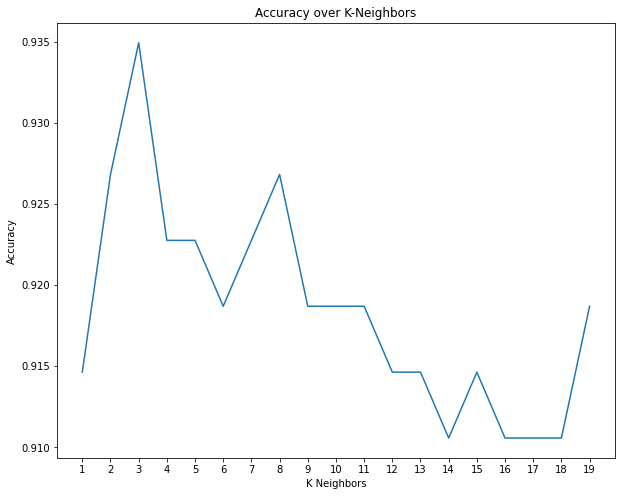

In [15]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.plot(range(1,20), scores)
ax.set_xticks(range(1,20))
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy over K-Neighbors")
plt.show()

### K-Neighbors Classifier

In [16]:
knn_rus = KNeighborsClassifier(n_neighbors=3)
knn_rus.fit(X_train, np.ravel(y_train))
knn_rus_predictions = knn_rus.predict(X_test)
knn_rus_predict_probs = knn_rus.predict_proba(X_test)[:, 1]
knn_FP_rate, knn_TP_rate, knn_threshold = roc_curve(y_test, knn_rus_predict_probs)

### Random Forest Classifier

In [17]:
forest_rus = RandomForestClassifier()
forest_rus.fit(X_train, np.ravel(y_train))
forest_rus_predictions = forest_rus.predict(X_test)
forest_rus_predict_probs = forest_rus.predict_proba(X_test)[:, 1]
forest_FP_rate, forest_TP_rate, forest_threshold = roc_curve(y_test, forest_rus_predict_probs)

### Support Vector Classification

In [18]:
svc_rus = SVC(probability=True)
svc_rus.fit(X_train, np.ravel(y_train))
svc_rus_predictions = svc_rus.predict(X_test)
svc_rus_predict_probs = svc_rus.predict_proba(X_test)[:, 1]
svc_FP_rate, svc_TP_rate, svc_threshold = roc_curve(y_test, svc_rus_predict_probs)

## Measuring Models Trained on Undersampled Data
In this case, the data is split evenly, which means we actually can use accuracy to calculate how effective its predictions are. 

### Comparing Accuracy
Overall, it looks like the Logistic Regression model and K-Nearest Neighbors classifier provide the best accuracy at 93.5%. The Random Forest Classifier is not far behind at 93.09%, however.

In [19]:
print("Logistic Regression Model accuracy: {0:.2f}%".format(accuracy_score(y_test, lr_rus_predictions) * 100))
print("Decision Tree Classifier accuracy: {0:.2f}%".format(accuracy_score(y_test, tree_rus_predictions) * 100))
print("K-Nearest Neighbors Classifier accuracy: {0:.2f}%".format(accuracy_score(y_test, knn_rus_predictions) * 100))
print("Random Forest Classifier accuracy: {0:.2f}%".format(accuracy_score(y_test, forest_rus_predictions) * 100))
print("Support Vector Classification accuracy: {0:.2f}%".format(accuracy_score(y_test, svc_rus_predictions) * 100))

Logistic Regression Model accuracy: 93.50%
Decision Tree Classifier accuracy: 86.99%
K-Nearest Neighbors Classifier accuracy: 93.50%
Random Forest Classifier accuracy: 91.87%
Support Vector Classification accuracy: 91.87%


### Plotting Receiver Operating Characteristics (ROC) Curve
When our data is balanced, we can plot a ROC curve and then measure the area under the curve to see how accurate our model is.

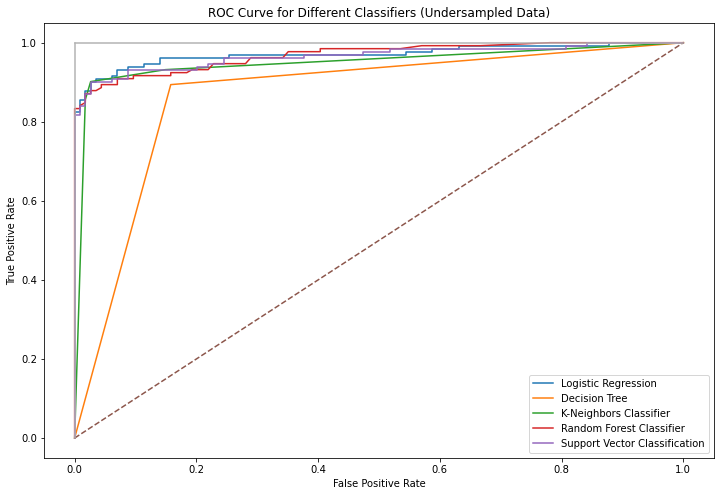

In [20]:
plt.figure(figsize=(12,8))
plt.plot(lr_FP_rate, lr_TP_rate, label='Logistic Regression')
plt.plot(tree_FP_rate, tree_TP_rate, label='Decision Tree')
plt.plot(knn_FP_rate, knn_TP_rate, label='K-Neighbors Classifier')
plt.plot(forest_FP_rate, forest_TP_rate, label='Random Forest Classifier')
plt.plot(svc_FP_rate, svc_TP_rate, label='Support Vector Classification')
plt.plot([0,1], ls='--')
plt.plot([0,0], [1,0], c=".7"), plt.plot([1,1], c=".7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Different Classifiers (Undersampled Data)")
plt.legend()
plt.show()

### Analysis using AUROC (Area Under Receiver Operating Characteristics)
Finally, we can calculate the area under the curve for our plotted curve, and receive an overall score for each model. Interestingly, while our Logistic Regression Model is still on top, Random Forest Classification and Support Vector Classification now beat K-Nearest Neighbor classifications under this metric.

In [21]:
print("Logistic Regression Model AUROC score: {0}".format(roc_auc_score(y_test, lr_rus_predict_probs)))
print("Decision Tree Classifier AUROC score: {0}".format(roc_auc_score(y_test, tree_rus_predict_probs)))
print("K-Nearest Neighbors Classifier AUROC score: {0}".format(roc_auc_score(y_test, knn_rus_predict_probs)))
print("Random Forest Classifier AUROC score: {0}".format(roc_auc_score(y_test, forest_rus_predict_probs)))
print("Support Vector Classification AUROC score: {0}".format(roc_auc_score(y_test, svc_rus_predict_probs)))

Logistic Regression Model AUROC score: 0.9713583200425308
Decision Tree Classifier AUROC score: 0.8680223285486444
K-Nearest Neighbors Classifier AUROC score: 0.9496610845295055
Random Forest Classifier AUROC score: 0.9685007974481659
Support Vector Classification AUROC score: 0.966241360978203


## Oversampled Data

### Random Oversampling
Another way we can attempt to balance data is to oversample the minority class. `RandomOverSampler` will take random observations from the minority class and duplicate them until it has the same count as the majority class. We can observe that if we do this, we'll end up with a fairly large dataset. Both classes will now have 284,315 observations.




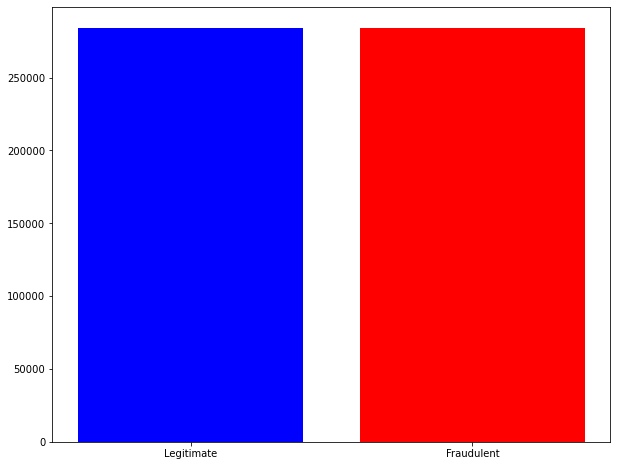

Counter({0: 284315, 1: 284315})


In [22]:
ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_resample(X, y)
ros_data = Counter(y_ros)
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.bar(ros_data.keys(), ros_data.values(), color=['blue', 'red'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Legitimate', 'Fraudulent'])
plt.show()
print(ros_data)

### Potential Problems
Oversampling is not a perfect solution, either. With this dataset in particular, scaling the minority class to have the same amount of rows as the majority class means we have very specific duplicates for "fraudulent" observations. This increases the likelihood of overfitting. The model will train on highly specific data, learn to recognize those patterns, but if presented with a real world example of fraud it hasn't seen yet, it may fail to classify it as fraud.

### Training on Oversampled Data
Once more, we'll split the data into a training and testing set, then use machine learning models to make predictions. Here we'll use Logistic Regression and a Decision Tree. Due to the size of the data, many models will take a long time to train, without necessarily providing a significant increase in accuracy.

### Splitting the Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, random_state=1, test_size=0.15)

### Logistic Regression

In [24]:
lr_ros = LogisticRegression()
lr_ros.fit(X_train, y_train)
lr_ros_predictions = lr_ros.predict(X_test)
lr_ros_predict_probs = lr_ros.predict_proba(X_test)[:, 1]
lr_ros_FP_rate, lr_ros_TP_rate, lr_ros_threshold = roc_curve(y_test, lr_ros_predict_probs)

### Decision Tree Classifier

In [25]:
tree_ros = DecisionTreeClassifier()
tree = tree_ros.fit(X_train, y_train)
tree_ros_predictions = tree_ros.predict(X_test)
tree_ros_predict_probs = tree_ros.predict_proba(X_test)[:, 1]
tree_ros_FP_rate, tree_ros_TP_rate, tree_ros_threshold = roc_curve(y_test, tree_ros_predict_probs)

## Measuring Models Trained on Oversampled Data
As we have an equal number of observations for both classes, we can once again use accuracy to measure how effective the model's predictions are.

### Comparing Accuracy


In [26]:
print("Logistic Regression Model accuracy: {0:.2f}%".format(accuracy_score(y_test, lr_ros_predictions) * 100))
print("Decision Tree Classifier accuracy: {0:.2f}%".format(accuracy_score(y_test, tree_ros_predictions) * 100))

Logistic Regression Model accuracy: 94.83%
Decision Tree Classifier accuracy: 99.98%


### Plotting Receiver Operating Characteristics (ROC) Curve

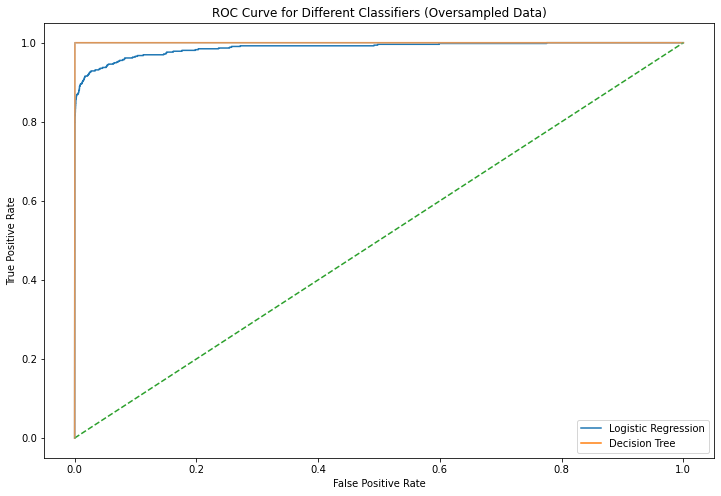

In [27]:
plt.figure(figsize=(12,8))
plt.plot(lr_ros_FP_rate, lr_ros_TP_rate, label='Logistic Regression')
plt.plot(tree_ros_FP_rate, tree_ros_TP_rate, label='Decision Tree')
plt.plot([0,1], ls='--')
plt.plot([0,0], [1,0], c=".7", alpha=0.6), plt.plot([1,1], c=".7", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Different Classifiers (Oversampled Data)")
plt.legend()
plt.show()

### Analysis using AUROC (Area Under Receiver Operating Characteristics)

In [28]:
print("Logistic Regression Model AUROC score: {0}".format(roc_auc_score(y_test, lr_ros_predict_probs)))
print("Decision Tree Classifier AUROC score: {0}".format(roc_auc_score(y_test, tree_ros_predict_probs)))

Logistic Regression Model AUROC score: 0.9870100964908856
Decision Tree Classifier AUROC score: 0.9997894047173344


### Overfitting?
One potential problem with oversampling that was mentioned earlier is overfitting. Generally, predictions are tested against a validation set, but it's important to remember that our validation set in this case is likely to contain many duplicates of the same cases. It's important to keep in mind as we look at these scores.

# Using A Combinationg of Sampling Techniques
For our final line of predictions, we'll use a combination of sampling techniques. In this section we will first oversample using SMOTE (Synthetic Minority Oversampling Technique), then undersample our dataset. This way, we'll increase the amount of observations in the minority class, then bring the majority class down to meet it. This will have the benefits of undersampling, with the benefits of oversampling.

### SMOTE (Synthetic Minority Oversampling TEchnique)
Our previous attempt at oversampling created exact duplicates of our observations. The problem with doing that is that our model learned to detect very specific cases of fraudulent transactions and may not have been as effective at detecting different real world examples. SMOTE seeks to balance the data without duplicating values exactly. It will pick a random point in the minority class, find its K-Nearest Neighbors, pick a random neighbor, then create an observation that falls somewhere in between. 

This will be our first step. We'll oversample using SMOTE, but instead of matching the amount of observations in the majority class, we'll go up to 5% of the total values in the majority class.

In [29]:
osmote = SMOTE(sampling_strategy=0.05)
X_os, y_os = osmote.fit_resample(X, y)
print(Counter(y_os))

Counter({0: 284315, 1: 14215})


### Undersampling After SMOTE
Now that we've oversampled the minority class to 10% of the majority class, we'll undersample the majority class so that our ration ends up being 2:1. We're still creating imbalanced data here, and the objective will be to measure it once more using AUPRC, to see how much better it fares when we use this combination of techniques.

In [30]:
rus_os = RandomUnderSampler(sampling_strategy=0.5)
X_bal, y_bal = rus_os.fit_resample(X_os, y_os)
print(Counter(y_bal))

Counter({0: 28430, 1: 14215})


### Splitting the Data

### Training on Data Balanced With SMOTE + Undersampling
This should, theoretically, comprise a fairly balanced dataset at this point. We've covered one of the primary weaknesses of Oversampling by both reducing how much we're oversampling by, and also by creating synthetic data rather than exact duplicates. By oversampling the data first, we're also creating more overall observations once we undersample, covering that technique's primary weakness, as well.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, random_state=1)

### Logistic Regression

In [32]:
lr_bal = LogisticRegression()
lr_bal.fit(X_train, np.ravel(y_train))
lr_bal_predictions = lr_bal.predict(X_test)
lr_bal_predict_probs = lr_bal.predict_proba(X_test)[:, 1]
lr_bal_prec, lr_bal_recall, lr_bal_threshold = precision_recall_curve(y_test, lr_bal_predict_probs)

### Decision Tree Classifier

In [33]:
tree_bal = DecisionTreeClassifier()
tree = tree_bal.fit(X_train, np.ravel(y_train))
tree_bal_predictions = tree_bal.predict(X_test)
tree_bal_predict_probs = tree_bal.predict_proba(X_test)[:, 1]
tree_bal_prec, tree_bal_recall, tree_bal_threshold = precision_recall_curve(y_test, tree_bal_predict_probs)

### K-Nearest Neighbors Classifier

In [34]:
knn_bal = KNeighborsClassifier(n_neighbors=3)
knn_bal.fit(X_train, np.ravel(y_train))
knn_bal_predictions = knn_bal.predict(X_test)
knn_bal_predict_probs = knn_bal.predict_proba(X_test)[:, 1]
knn_bal_prec, knn_bal_recall, knn_bal_threshold = precision_recall_curve(y_test, knn_bal_predict_probs)

## Measuring Models Trained on SMOTE + Undersampled Data

### Plotting Precision-Recall Curve
Our data presents a slight imbalance, so we won't be able to rely on accuracy alone. Let's start by plotting Precision-Recall Curves for our classifiers then calculating the area under it.

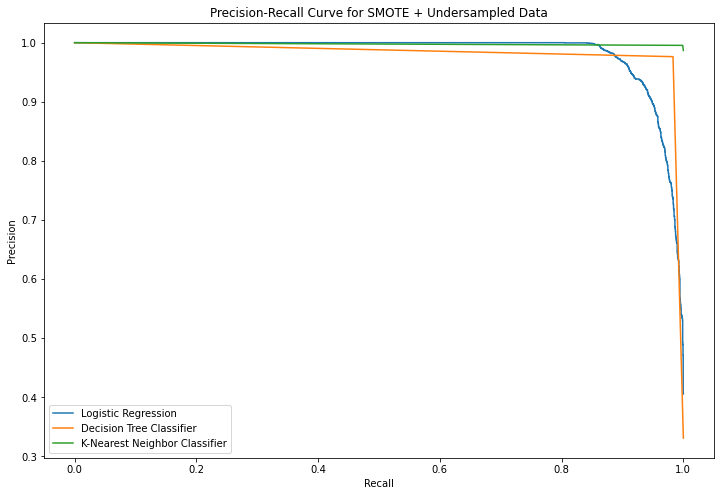

AUPRC for Logistic Regression Model: 0.9839125150047482
AUPRC for Decision Tree Classifier: 0.9824917428838208
AUPRC for K-Nearest Neighbor Classifier: 0.9977333025310653


In [35]:
plt.figure(figsize=(12,8))
plt.plot(lr_bal_recall, lr_bal_prec, label="Logistic Regression")
plt.plot(tree_bal_recall, tree_bal_prec, label="Decision Tree Classifier")
plt.plot(knn_bal_recall, knn_bal_prec, label="K-Nearest Neighbor Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve for SMOTE + Undersampled Data")
plt.show()
print("AUPRC for Logistic Regression Model: {0}".format(auc(lr_bal_recall, lr_bal_prec)))
print("AUPRC for Decision Tree Classifier: {0}".format(auc(tree_bal_recall, tree_bal_prec)))
print("AUPRC for K-Nearest Neighbor Classifier: {0}".format(auc(knn_bal_recall, knn_bal_prec)))

### Analyzing AUPRC Results
These results are significantly better than the last time we attempted to use imbalanced data! Our K-Nearest Neighbor model classified data almost perfectly. 

### Confusion Matrix
Another way to visualize predictions vs. actual labels is to use a confusion matrix. This will show us a detailed breakdown of all the predictions made by the model. We'll visualize the results of the K-Nearest Neighbors predictions.

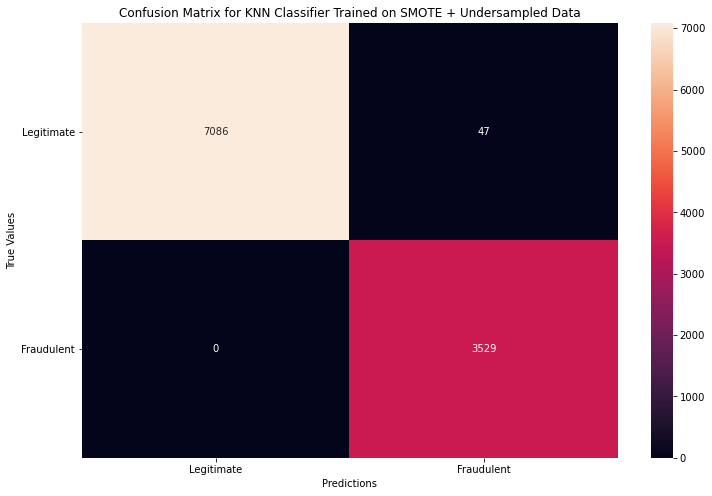

In [36]:
knn_cm = confusion_matrix(y_test, knn_bal_predictions)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(knn_cm, annot=True, fmt='d')
ax.set_xticklabels(['Legitimate', 'Fraudulent'])
ax.set_yticklabels(['Legitimate', 'Fraudulent'], rotation=360)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Confusion Matrix for KNN Classifier Trained on SMOTE + Undersampled Data")
plt.show()

### Analyizing Confusion Matrix
The numbers show the predictions made by the model and their real values. It predicted all fraudulent cases correctly, while only predicting 58 legitimate cases as fraudulent. This is the ideal way for the model to work, it's better to flag certain legitimate transactions as potentially fraudulent and find out more by investigating, than to miss a real fraudulent transaction.

# Conclusion

In this project, we've balanced data in three different ways and measured both the imbalance dataset and the different balancing techniques using a number of metrics and visualizations.

## Further Research
More data on fraudulent cases would be extremely helpful in improving these models. Even when oversampling to just 5% of the total dataset and using techniques that create synthetic data points, we run the risk of creating highly-specific data. Our classifiers will find it difficult to interpret anything outside these parameters, and previously unseen cases of fraud may slip through the cracks.